# ***Stock Market Return Prediction using LightGBM & Technical Analysis***

Overview
This notebook builds a stock return prediction pipeline using historical stock data, technical indicators, and machine learning — specifically LightGBM, a fast, efficient gradient boosting framework.

We walk through the full modeling process:

* Fetch historical stock data using yfinance

Technical indicators see below:

Train a LightGBM model to predict 5-day forward returns

Evaluate performance on held-out real-world data (e.g., MAPE, direction accuracy)

* 1.) Creation of a weak model, defined as slightly better than the random one, trained on the data
* 2.)Construction of a second model in an attempt to correct the errors of the first one. The gradient descent algorithm minimises the errors; each tree is added to compensate for the errors made previously, without damaging the predictions that were correct.
* 3.)Other models are added until the predictions are accurate enough, or the selected maximum number of models has been reached.
* 4.)The sum of the predictions of all trees will be the final predictions.

![image.png](https://images.storychief.com/account_16771/boosting_10637717a55161cac7add365c33c213a_800.png)

Doing regression, because you’re predicting numeric returns and prices.

Used LGBMRegressor, which is the right model for that.
* the future 5-day return of a given stock.

First lets imports all the necessary libraries required for data collection, processing, visualization, machine learning, and evaluation

In [246]:
#numbpy version need to downgrade for pandas_ta library to work in colab

import numpy as np
np.__version__
!pip install pandas_ta  # No compilation needed
!pip install numpy==1.24.0  # Downgrade to last stable v1.x

In [247]:
import yfinance as yf
import numpy as np

import pandas as pd
import pandas_ta as ta


import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error



import random
np.random.seed(42)
random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from datetime import timedelta



Read stock data and make sure its a valid ticker:

In [248]:
while True:
    ticker = input("Enter stock ticker (e.g. AAPL, MSFT, TSLA): ").upper()
    start_date = '2005-01-01'

    # Set how many days before today you want as the end date (easy to change later)
    days_before_today = 0  # Change to 7 for a week before, etc.
    end_date = (pd.Timestamp.today() - pd.Timedelta(days=days_before_today)).strftime('%Y-%m-%d')

    try:
        print(f"\nDownloading {ticker} data from {start_date} to {end_date}...")
        df_original = yf.download(ticker, start=start_date, end=end_date)
        if df_original.empty:
            print(f"Error: '{ticker}' returned no data. Please try again.\n")
        else:
            print(f"Successfully downloaded data for '{ticker}' — {len(df_original)} rows.\n")
            break
    except Exception as e:
        print(f"Error downloading data for '{ticker}': {e}\n")


Enter stock ticker (e.g. AAPL, MSFT, TSLA): t



[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for 'T' — 5106 rows.



Column Normalization for MultiIndex & #force lowercase + append ticker)


In [249]:
df_original.columns = [f"{col[0].lower()}_{ticker.lower()}" if isinstance(df_original.columns, pd.MultiIndex)
             else f"{col.lower()}_{ticker.lower()}"
             for col in df_original.columns]

Show the DataFrame

In [250]:
df = df_original.copy()
df


,close_t,high_t,low_t,open_t,volume_t
Date,,,,,
2005-01-03,4.485113,4.553467,4.479854,4.553467,13108262
2005-01-04,4.437790,4.518413,4.437790,4.514908,15728061
2005-01-05,4.458821,4.520165,4.455316,4.457069,14649398
2005-01-06,4.483361,4.522579,4.460187,4.522579,11942480
2005-01-07,4.470883,4.524362,4.467317,4.501188,13383124
...,...,...,...,...,...
2025-04-11,26.790001,26.900000,26.360001,26.580000,32057600
2025-04-14,27.200001,27.350000,26.580000,26.629999,27042800
2025-04-15,27.500000,27.629999,27.260000,27.500000,25721300


Compute Daily Returns

Note: This calculated return is going to be used as the target variable for regression modeling with LightGBM.

In [251]:
# Calculate returns BEFORE slicing
df['Actual_Return'] = df[f'close_{ticker.lower()}'].pct_change()
df = df.dropna().copy()  # # Remove rows with missing target
# df

These represent the most recent 5 trading days, and are saved before performing operation drop rows.

These rows are set aside for later comparison with model predictions, simulating how the model would perform on unseen "future" data.





In [252]:
actual_data = df.iloc[-5:].copy()

In [253]:
actual_data

,close_t,high_t,low_t,open_t,volume_t,Actual_Return
Date,,,,,,
2025-04-11,26.790001,26.900000,26.360001,26.580000,32057600,0.015157
2025-04-14,27.200001,27.350000,26.580000,26.629999,27042800,0.015304
2025-04-15,27.500000,27.629999,27.260000,27.500000,25721300,0.011029
2025-04-16,27.020000,27.780001,26.940001,27.740000,27835900,-0.017455
2025-04-17,27.150000,27.490000,27.010000,27.180000,24760000,0.004811


remove the latest 5 so we can predict this week's and compare later on

In [254]:
# Define the close column name (works for any ticker)
close_col = f"close_{ticker.lower()}"  # e.g., "close_aapl"
close_col

'close_t'

In [255]:
df

,close_t,high_t,low_t,open_t,volume_t,Actual_Return
Date,,,,,,
2005-01-04,4.437790,4.518413,4.437790,4.514908,15728061,-0.010551
2005-01-05,4.458821,4.520165,4.455316,4.457069,14649398,0.004739
2005-01-06,4.483361,4.522579,4.460187,4.522579,11942480,0.005504
2005-01-07,4.470883,4.524362,4.467317,4.501188,13383124,-0.002783
2005-01-10,4.438794,4.474447,4.406706,4.474447,16073492,-0.007177
...,...,...,...,...,...,...
2025-04-11,26.790001,26.900000,26.360001,26.580000,32057600,0.015157
2025-04-14,27.200001,27.350000,26.580000,26.629999,27042800,0.015304
2025-04-15,27.500000,27.629999,27.260000,27.500000,25721300,0.011029


# **Technical indicators**

we will add:
* lag returns for days 1,2,5,10,20 & also for volume
* Rolling stats:
  * 5 day moving average / 5-day mva with 5 day lag
  * 10 day rolling standard deviation (for volatility)
* 14 day RSI measures speed & change of price moves; overbought/oversold conditions


In [256]:
for lag in [1, 2, 5, 10, 20]:
    df[f'return_lag_{lag}'] = df[close_col].pct_change(lag)
# Lag volume changes
for lag in [5, 10, 20]:
    df[f'volume_change_lag_{lag}'] = df[f'volume_{ticker.lower()}'].pct_change(lag)

# Rolling stats
df['rolling_5_mean'] = df[close_col].rolling(5).mean()
df['rolling_5_mean_lagged'] = df[close_col].shift(5).rolling(5).mean()
df['rolling_10_std'] = df[close_col].rolling(10).std()
df['rolling_10_lagged'] = df['return_lag_5'].rolling(10).std()


#RSI
df['rsi_14'] = ta.rsi(df[close_col], length=14)

* MACD: (Moving Average Convergence/Divergence)
 * When the MACD line crosses above the signal line → bullish signal
 * When it crosses below → bearish signal.
 * The magnitude of the MACD can reflect trend strength.


Bolinger Bands: volatility based ta
* Middle Band = 20-day Simple Moving Average (SMA) of the closing price
* Upper Band = Middle Band + (2 × 20-day Standard Deviation)
* Lower Band = Middle Band − (2 × 20-day Standard Deviation)
* band distance gives a normalized signal of price position, regardless of volatility.
* Band width capture volatilit of market




In [257]:
# MACD (difference between 12-period and 26-period EMAs(exponential moving average))
# The Signal line (9-period EMA of MACD line)

macd = ta.macd(df[close_col], fast=12, slow=26, signal=9)
df['macd'] = macd['MACD_12_26_9']  # Just the MACD line
df['macd_signal'] = macd['MACDs_12_26_9']
df['macd_histogram'] = macd['MACDh_12_26_9'] #histogram is often more informative for momentum strength and timing.


#Bollinger Bands
bbands = ta.bbands(df[close_col], length=20)
df['upper_band'] = bbands['BBU_20_2.0']  #default 2.0 standard deviation over 20 day window
df['middle_band'] = bbands['BBM_20_2.0']
df['lower_band'] = bbands['BBL_20_2.0']
df['band_distance'] = (df[close_col] - df['middle_band']) / (df['upper_band'] - df['lower_band'])
df['band_width'] = df['upper_band'] - df['lower_band']

Combine large returns with high volatility to potentially capture extreme event signals

In [258]:
df['lag20_vol_interaction'] = df['return_lag_20'] * df['rolling_10_std']
df[f'volume_lag20_interaction'] = df[f'volume_{ticker.lower()}'] * df[f'return_lag_20']


Implement Z score
* high positive z score--> unusual buying or selling activity
Vix Data Volatility Index
* downloads a real world measure of market fear
 * High vix = high uncerntainty --> higher risk or volatility

In [259]:
df[f'volume_zscore'] = (
    (df[f'volume_{ticker.lower()}'] - df[f'volume_{ticker.lower()}'].rolling(20).mean()) /
    df[f'volume_{ticker.lower()}'].rolling(20).std()
)

vix_data = yf.download('^VIX', start=start_date)
df['vix_close'] = vix_data['Close'].shift(5)


[*********************100%***********************]  1 of 1 completed


download sp500 data and merge to df and add ta from sp500

In [260]:


sp500 = yf.download('^GSPC', start= start_date)
sp500['sp500_return'] = sp500['Close'].pct_change()



#flatten multi index columns to merge
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = ['_'.join(col).strip().lower() for col in sp500.columns.values]
else:
    sp500.columns = [col.lower() for col in sp500.columns]

# ensure datetime index
sp500.index = pd.to_datetime(sp500.index)
df.index = pd.to_datetime(df.index)

sp500['sp500_return_'] = sp500['close_^gspc'].pct_change()
sp500['sp500_return_lag5'] = sp500['sp500_return_'].shift(5)
sp500['sp500_rolling_5'] = sp500['sp500_return_'].rolling(5).mean().shift(1)

# merge
sp500_features = sp500[['sp500_return_lag5', 'sp500_rolling_5']]

#merge into main df
df = df.merge(sp500_features, left_index=True, right_index=True, how='left')

[*********************100%***********************]  1 of 1 completed


In [261]:
df

,close_t,high_t,low_t,open_t,volume_t,Actual_Return,return_lag_1,return_lag_2,return_lag_5,return_lag_10,...,middle_band,lower_band,band_distance,band_width,lag20_vol_interaction,volume_lag20_interaction,volume_zscore,vix_close,sp500_return_lag5,sp500_rolling_5
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,4.437790,4.518413,4.437790,4.514908,15728061,-0.010551,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,4.458821,4.520165,4.455316,4.457069,14649398,0.004739,0.004739,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,4.483361,4.522579,4.460187,4.522579,11942480,0.005504,0.005504,0.010269,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,4.470883,4.524362,4.467317,4.501188,13383124,-0.002783,-0.002783,0.002705,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,4.438794,4.474447,4.406706,4.474447,16073492,-0.007177,-0.007177,-0.009940,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.080000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-11,26.790001,26.900000,26.360001,26.580000,32057600,0.015157,0.015157,0.022831,0.016304,-0.039235,...,27.011524,25.581762,-0.077468,2.859524,0.016616,5.962238e+05,-0.889937,45.310001,-0.059750,-0.003447
2025-04-14,27.200001,27.350000,26.580000,26.629999,27042800,0.015304,0.015304,0.030693,0.024551,-0.027981,...,27.044113,25.628434,0.055058,2.831357,0.020550,6.639234e+05,-1.086797,46.980000,-0.002331,0.012121
2025-04-15,27.500000,27.629999,27.260000,27.500000,25721300,0.011029,0.011029,0.026502,0.053122,-0.024161,...,27.102586,25.713271,0.143025,2.778630,0.033446,1.142411e+06,-1.131475,52.330002,-0.015701,0.014177


In [262]:
pred = df.copy() #copy to use for actual forecasting

Calculate 5-day returns and drop nans

In [263]:
df.loc[:, '5_day_return'] = df[close_col].pct_change(5).shift(-5)
df = df.dropna().copy()

In [264]:
df['target_high_return'] = (df['5_day_return'] > df['5_day_return'].quantile(0.9)).astype(int)


Check df and drop nans/0's

In [265]:
df = df.dropna().copy()  #remove rows with missing target


In [266]:
df

,close_t,high_t,low_t,open_t,volume_t,Actual_Return,return_lag_1,return_lag_2,return_lag_5,return_lag_10,...,band_distance,band_width,lag20_vol_interaction,volume_lag20_interaction,volume_zscore,vix_close,sp500_return_lag5,sp500_rolling_5,5_day_return,target_high_return
Date,,,,,,,,,,,,,,,,,,,,,
2005-02-22,4.283702,4.367487,4.278354,4.328269,15994052,-0.006204,-0.006204,-0.009072,-0.013952,-0.017981,...,-0.188641,0.221606,-0.000706,-3.323902e+05,-0.296329,11.520000,0.000697,-0.000609,0.012069,0
2005-02-23,4.303314,4.321141,4.258748,4.285488,14219495,0.004578,0.004578,-0.001654,-0.015497,-0.019097,...,-0.088217,0.220242,-0.000380,-1.802849e+05,-0.517392,11.270000,0.003300,-0.003650,0.007456,0
2005-02-24,4.306877,4.322921,4.276572,4.292616,8454005,0.000828,0.000828,0.005410,-0.014280,-0.009024,...,-0.056708,0.213771,-0.000509,-1.444566e+05,-1.107361,11.100000,0.000182,-0.003188,0.008279,0
2005-02-25,4.315789,4.322920,4.265875,4.310442,10097354,0.002069,0.002069,0.002899,-0.001650,0.004564,...,-0.041477,0.193443,0.000648,2.303520e+05,-0.862709,11.770000,-0.007923,-0.001646,0.011566,0
2005-02-28,4.289051,4.317573,4.278355,4.317573,10970399,-0.006195,-0.006195,-0.004139,-0.004963,-0.008244,...,-0.231636,0.167002,0.000570,2.043618e+05,-0.679767,11.180000,0.000700,0.001800,0.014962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-04,26.360214,28.131416,26.251371,27.705932,61361000,-0.068531,-0.068531,-0.053305,-0.054649,-0.014064,...,-0.169045,3.339391,-0.011744,-1.086039e+06,0.908991,21.650000,-0.019737,-0.010417,0.016304,0
2025-04-07,26.548220,26.944018,24.836389,24.915549,74875400,0.007132,0.007132,-0.061888,-0.051273,-0.004822,...,-0.105599,3.354582,-0.011272,-1.235116e+06,1.584511,22.280001,0.005539,-0.018419,0.024551,0
2025-04-08,26.112839,26.904438,25.756621,26.736223,55717100,-0.016400,-0.016400,-0.009384,-0.073385,-0.033687,...,-0.247611,3.264876,0.011816,8.140094e+05,0.570130,21.770000,0.003781,-0.019993,0.053122,1


In [267]:
print(df.columns.tolist())


['close_t', 'high_t', 'low_t', 'open_t', 'volume_t', 'Actual_Return', 'return_lag_1', 'return_lag_2', 'return_lag_5', 'return_lag_10', 'return_lag_20', 'volume_change_lag_5', 'volume_change_lag_10', 'volume_change_lag_20', 'rolling_5_mean', 'rolling_5_mean_lagged', 'rolling_10_std', 'rolling_10_lagged', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'upper_band', 'middle_band', 'lower_band', 'band_distance', 'band_width', 'lag20_vol_interaction', 'volume_lag20_interaction', 'volume_zscore', 'vix_close', 'sp500_return_lag5', 'sp500_rolling_5', '5_day_return', 'target_high_return']


# **Prep work for: Training Models**

Define Features and Target, Split Data

Check Predictions vs. Actual Returns (Last 5 Days)


In [268]:
# # Get the last 5 days of data (all features pre-computed) will be replacing with predicted future data
future_data = df.iloc[-5:].copy()

In [269]:
# Set dates to the next 5 trading days
last_date = df.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=5,
    freq='B'  # Business days only
)
future_data.index = future_dates  # Update dates

# Drop the target column ('5_day_return') if it exists
future_data = future_data.drop(columns=['5_day_return'], errors='ignore')

Ensure Feature Columns Match Training Data


In [270]:
future_data


,close_t,high_t,low_t,open_t,volume_t,Actual_Return,return_lag_1,return_lag_2,return_lag_5,return_lag_10,...,lower_band,band_distance,band_width,lag20_vol_interaction,volume_lag20_interaction,volume_zscore,vix_close,sp500_return_lag5,sp500_rolling_5,target_high_return
2025-04-11,26.360214,28.131416,26.251371,27.705932,61361000,-0.068531,-0.068531,-0.053305,-0.054649,-0.014064,...,25.255027,-0.169045,3.339391,-0.011744,-1.086039e+06,0.908991,21.650000,-0.019737,-0.010417,0
2025-04-14,26.548220,26.944018,24.836389,24.915549,74875400,0.007132,0.007132,-0.061888,-0.051273,-0.004822,...,25.225168,-0.105599,3.354582,-0.011272,-1.235116e+06,1.584511,22.280001,0.005539,-0.018419,0
2025-04-15,26.112839,26.904438,25.756621,26.736223,55717100,-0.016400,-0.016400,-0.009384,-0.073385,-0.033687,...,25.288822,-0.247611,3.264876,0.011816,8.140094e+05,0.570130,21.770000,0.003781,-0.019993,1
2025-04-16,26.191999,26.577905,24.935339,25.815991,77738700,0.003031,0.003031,-0.013418,-0.059346,-0.042676,...,25.431042,-0.250885,3.054647,0.026298,2.266873e+06,1.755639,21.510000,0.006728,-0.023890,0
2025-04-17,26.389999,26.760000,25.900000,26.240000,51467900,0.007560,0.007560,0.010614,-0.067479,-0.054252,...,25.526578,-0.204407,2.920976,0.020496,1.144370e+06,0.206970,30.020000,-0.048396,-0.006205,0


Show feature important & Drop Low-Impact Features


In [271]:
print(df.columns.tolist())


['close_t', 'high_t', 'low_t', 'open_t', 'volume_t', 'Actual_Return', 'return_lag_1', 'return_lag_2', 'return_lag_5', 'return_lag_10', 'return_lag_20', 'volume_change_lag_5', 'volume_change_lag_10', 'volume_change_lag_20', 'rolling_5_mean', 'rolling_5_mean_lagged', 'rolling_10_std', 'rolling_10_lagged', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'upper_band', 'middle_band', 'lower_band', 'band_distance', 'band_width', 'lag20_vol_interaction', 'volume_lag20_interaction', 'volume_zscore', 'vix_close', 'sp500_return_lag5', 'sp500_rolling_5', '5_day_return', 'target_high_return']


Train the model:

X = all the input features we want to use to make predictions
* (we drop the 5-day return so the model does not overfit aka cheat)

y = target we want to predict:
* 5 day return

In [272]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['5_day_return'])
y = df['5_day_return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train a model based on all feature to get feature importances
Feature Importances: tells us how much each feature contributes to the model's prediction. Feature importances matter to understand what drives the model
helps in look at which indicator are the most predictive

LightGBM allows for different ways to calculate importances:
* split: how many times a feature was used
* gain: how much each split reduced the loss

In [273]:
# First training (all features)
full_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    min_child_samples=20,
    feature_fraction=0.8,
    verbose=-1 #verbosity=-1: Fully silent — suppresses all logs, warnings, info, and debug.
)
full_model.fit(X_train, y_train)

LGBMRegressor(feature_fraction=0.8, learning_rate=0.01, max_depth=5,
              n_estimators=500, verbose=-1)

In [274]:
# Get initial importances
full_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': full_model.feature_importances_
}).sort_values('importance', ascending=False)


# Select top 3 features
top_features = full_importance_df.head(3)['feature'].tolist()
top_features

['vix_close', 'rolling_10_lagged', 'sp500_rolling_5']

# **Top 3 features Model:**

In [275]:
# Second training (top features only)
top3_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    min_child_samples=20,
    feature_fraction=0.8,
    verbose=-1 #verbosity=-1: Fully silent — suppresses all logs, warnings, info, and debug.
)
top3_model.fit(X_train[top_features], y_train)

LGBMRegressor(feature_fraction=0.8, learning_rate=0.01, max_depth=5,
              n_estimators=500, verbose=-1)

Taking a look at the full list of feature and their importance and get the top 3:

In [276]:
top3_importance_df = pd.DataFrame({
    'feature': top_features,
    'importance': top3_model.feature_importances_
}).sort_values('importance', ascending=False)

# Compare results
print("Full Model Feature Importances:")
print(full_importance_df)
print("\nTop Features Model Importances:")
print(top3_importance_df)



Full Model Feature Importances:
                     feature  importance
30                 vix_close         587
17         rolling_10_lagged         503
32           sp500_rolling_5         394
20               macd_signal         393
7               return_lag_2         316
33        target_high_return         314
5              Actual_Return         296
22                upper_band         284
31         sp500_return_lag5         278
16            rolling_10_std         255
10             return_lag_20         239
8               return_lag_5         233
21            macd_histogram         227
0                    close_t         226
24                lower_band         181
14            rolling_5_mean         181
18                    rsi_14         180
26                band_width         180
4                   volume_t         180
9              return_lag_10         174
15     rolling_5_mean_lagged         171
19                      macd         157
11       volume_change_la

<ipython-input-277-b8784f66fbd5>:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


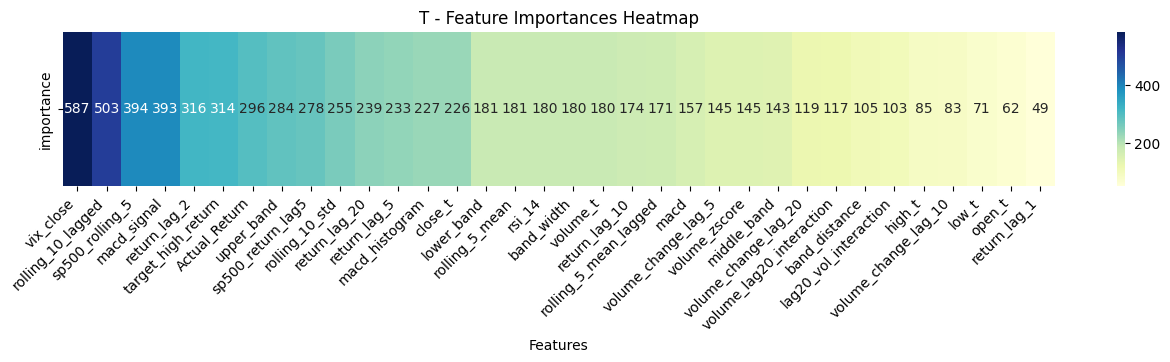

In [277]:
# plt.figure(figsize=(10, 6))

# # Plot feature importances
# lgb.plot_importance(full_model, title=f"{ticker} All Features Model")
# plt.tight_layout()
# plt.show()



importance_matrix = full_importance_df.set_index('feature').T

# Plot heatmap
plt.figure(figsize=(16, 2))  #width x height
sns.heatmap(
    importance_matrix,
    cmap='YlGnBu',        #colors
    annot=True,
    fmt='g',
    cbar=True
)

plt.title(f'{ticker} - Feature Importances Heatmap')
plt.xlabel('Features')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

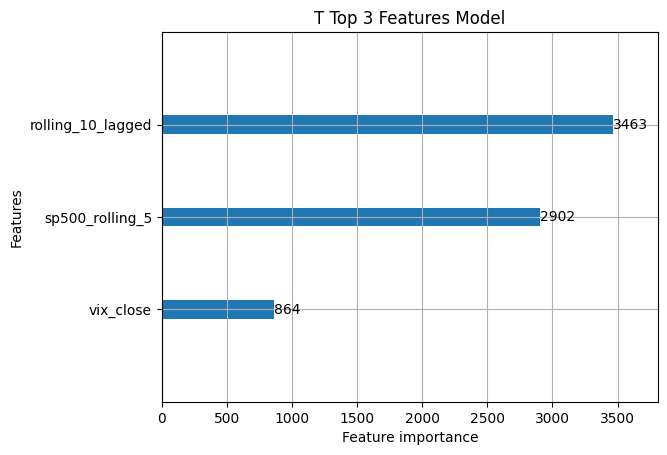

In [278]:
lgb.plot_importance(top3_model, title=f"{ticker} Top 3 Features Model")
plt.show()

In [279]:
#  prepares the simulated next-5-day data using only selected top features.
future_data_top = future_data[top_features]

all_features = X_train.columns.tolist()


predict on future_data using all columns

In [280]:
predicted_returns_top3 = top3_model.predict(future_data_top)  # Using top3_model here!

# returns to price predictions
last_price = df[close_col].iloc[-1]  # Last known price
predicted_prices_top3 = last_price * (1 + predicted_returns_top3).cumprod()

# prediction table:
future_predictions_top3 = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Return': predicted_returns_top3,
    'Predicted_Price': predicted_prices_top3
})



Ensure proper datetime format for actual data:

In [281]:
actual_data.index = pd.to_datetime(actual_data.index)


Merge predictions with actual data:

In [282]:

# Merge predictions with actuals using dynamic ticker name
comparison_top3_model = pd.merge(
    future_predictions_top3.set_index('Date'),
    actual_data[[f'close_{ticker.lower()}', 'Actual_Return']],
    left_index=True,
    right_index=True,
    how='left'
).rename(columns={
    f'close_{ticker.lower()}': 'Actual_Price'
})

print(comparison_top3_model)

            Predicted_Return  Predicted_Price  Actual_Price  Actual_Return
Date                                                                      
2025-04-11          0.011841        26.702492     26.790001       0.015157
2025-04-14          0.017273        27.163728     27.200001       0.015304
2025-04-15          0.006510        27.340573     27.500000       0.011029
2025-04-16          0.007786        27.553436     27.020000      -0.017455
2025-04-17          0.013406        27.922805     27.150000       0.004811


MAPE evaluates price-level accuracy (lower = better) **Mean Absolute Percentage Error**


* Measures how far off predicted prices were from actual prices in percentage terms.



Directional Accuracy shows if you're correctly predicting ups/downs (higher = better).

* Compares the direction (up or down) of returns instead of magnitude.
* This is useful for traders: even if your return value is off, getting the direction right.




For stocks, directional accuracy often matters more than absolute price error.



In [283]:
#drop nans
comparison_top3_model = comparison_top3_model.dropna()
mape = mean_absolute_percentage_error(comparison_top3_model['Actual_Price'],comparison_top3_model['Predicted_Price']) * 100  # Convert to %
print(f"MAPE: {mape:.2f}%")


# First ensure both series have matching indices
valid_mask = comparison_top3_model['Actual_Return'].notna() & comparison_top3_model['Predicted_Return'].notna()
actual_directions = np.sign(comparison_top3_model.loc[valid_mask, 'Actual_Return'])
predicted_directions = np.sign(comparison_top3_model.loc[valid_mask, 'Predicted_Return'])

# Now calculate accuracy
direction_accuracy = np.mean(actual_directions == predicted_directions) * 100
print(f"Directional Accuracy: {direction_accuracy:.2f}%")

MAPE: 1.17%
Directional Accuracy: 80.00%


In [284]:
def color_returns(val):
    color = 'red' if val < 0 else 'green'
    return f'color: {color}'

# styled_table = comparison_top3_model.style \
#     .format({'Predicted_Price': '{:.2f}',
#              'Actual_Price': '{:.2f}',
#              'Predicted_Return': '{:.2%}',
#              'Actual_Return': '{:.2%}'}) \
#     .applymap(color_returns, subset=['Predicted_Return', 'Actual_Return']) \
#     .set_caption(f'{ticker.upper()} Prediction Results') \
#     .background_gradient(cmap='Blues', subset=['Actual_Price', 'Predicted_Price'])

# display(styled_table)

In [285]:
def prepare_plot_data(df, price_cols=['Actual_Price', 'Predicted_Price']):
    df_clean = df.dropna(subset=price_cols).copy()
    df_clean.index = pd.to_datetime(df_clean.index)
    df_clean = df_clean[df_clean.index.dayofweek < 5]  # Keep only Mon–Fri
    df_clean = df_clean.sort_index()
    return df_clean



Price Plot

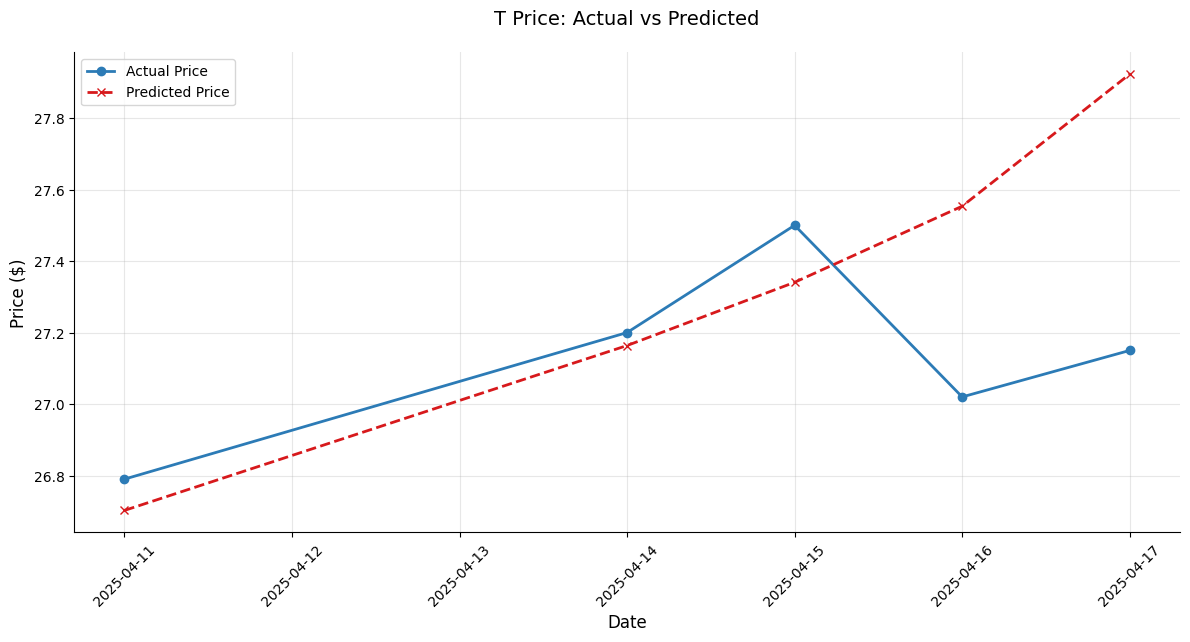

In [286]:
plot_data = prepare_plot_data(comparison_top3_model)

plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, plot_data['Actual_Price'], label='Actual Price', marker='o', linewidth=2, color='#2c7bb6')
plt.plot(plot_data.index, plot_data['Predicted_Price'], label='Predicted Price', linestyle='--', marker='x', linewidth=2, color='#d7191c')
plt.title(f'{ticker.upper()} Price: Actual vs Predicted', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


# new model: prep work:

Train LightGBM classifier to rank features:

In [287]:
df['target_direction'] = (df['5_day_return'] > 0).astype(int)


features = [col for col in df.columns if col not in [
    '5_day_return', 'Actual_Return', 'target_direction', 'target_high_return'
]]

X = df[features].dropna()
y = df.loc[X.index, 'target_direction']

clf = LGBMClassifier(n_estimators=500, learning_rate=0.01, max_depth=5, verbose=-1)
clf.fit(X, y)


LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=500, verbose=-1)

look at our feature importance

In [288]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(f"\nTop 10 features for {ticker.upper()} directional prediction:")
print(importance_df.head(10))


# 7. Generate next 5 business days
last_known_date = df.index[-1]
future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=5, freq='B')
print("\n📆 Future prediction window:")
print(future_dates)



Top 10 features for T directional prediction:
                 Feature  Importance
19           macd_signal         649
16     rolling_10_lagged         578
29             vix_close         404
15        rolling_10_std         389
20        macd_histogram         376
11  volume_change_lag_10         356
4               volume_t         335
5           return_lag_1         328
21            upper_band         321
25            band_width         300

📆 Future prediction window:
DatetimeIndex(['2025-04-11', '2025-04-14', '2025-04-15', '2025-04-16',
               '2025-04-17'],
              dtype='datetime64[ns]', freq='B')


#**Hybrid Model:**

This hybrid model combines
* A classifier (predicts up/down movement)
* A regressor (predicts numeric return)

Uses the top n(5) most important feature from prior model important ranking

Both models are trained on these features only


A hybrid direction signal is created when both models agree the price will go up
* reduces false positive by requiring confirmation from both

Feature Selection:

In [289]:
# Top N important features from earlier importance_df
n = 5

top_features = importance_df.head(n)['Feature'].tolist()

prepare training data:


In [290]:
X_top = df[top_features].dropna()
y_top = df.loc[X_top.index, 'target_direction']


train classifier:

In [291]:
from lightgbm import LGBMClassifier

clf_top = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    min_child_samples=20,
    verbose=-1
)
clf_top.fit(X_top, y_top)


LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=500, verbose=-1)

train regressor:

In [292]:
y_reg = df.loc[X_top.index, '5_day_return']

reg_top5 = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    min_child_samples=20,
    verbose=-1
)
reg_top5.fit(X_top, y_reg)


LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=500, verbose=-1)

Make predictions:

In [293]:
future_data_top = future_data[top_features]
predicted_returns_top = reg_top5.predict(future_data_top)

# convert to predicted prices using compounding
last_price = df[close_col].iloc[-1]
predicted_prices_top = last_price * (1 + predicted_returns_top).cumprod()

#prediction DataFrame
future_predictions_hybrid = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Return': predicted_returns_top,
    'Predicted_Price': predicted_prices_top
})


Merge df with actual df and compare:

In [294]:
actual_data.index = pd.to_datetime(actual_data.index)

comparison_hybrid_model = pd.merge(
    future_predictions_hybrid.set_index('Date'),
    actual_data[[f'close_{ticker.lower()}', 'Actual_Return']],
    left_index=True,
    right_index=True,
    how='left'
).rename(columns={
    f'close_{ticker.lower()}': 'Actual_Price',
    'Predicted_Price': 'Predicted_Price',
    'Predicted_Return': 'Predicted_Return'
})



Print out the comparison:

In [295]:
# Show top model results
print(f"📊 {ticker.upper()} Prediction vs Actual Comparison (Top Features Model):")
display(comparison_hybrid_model.round(2))

actual_direction = (comparison_hybrid_model['Actual_Return'] > 0).astype(int)
predicted_direction = (comparison_hybrid_model['Predicted_Return'] > 0).astype(int)

#compute directional accuracy
directional_accuracy = (actual_direction == predicted_direction).mean() * 100
print(f"📈 Directional Accuracy: {directional_accuracy:.2f}%")

📊 T Prediction vs Actual Comparison (Top Features Model):


,Predicted_Return,Predicted_Price,Actual_Price,Actual_Return
Date,,,,
2025-04-11,0.00,26.48,26.79,0.02
2025-04-14,0.01,26.81,27.20,0.02
2025-04-15,0.01,27.08,27.50,0.01
2025-04-16,0.02,27.67,27.02,-0.02
2025-04-17,0.01,28.03,27.15,0.00


📈 Directional Accuracy: 80.00%


Predict directions & combine

In [296]:
clf_pred_direction = clf_top.predict(future_data_top)
reg_top5_pred_direction = (predicted_returns_top > 0).astype(int)


hybrid_direction = ((clf_pred_direction == 1) & (reg_top5_pred_direction == 1)).astype(int)

evaluate hybrid accuracy

In [297]:
actual_direction = (comparison_hybrid_model['Actual_Return'] > 0).astype(int).reset_index(drop=True)
hybrid_accuracy = (actual_direction == hybrid_direction).mean() * 100

print(f"Hybrid Directional Accuracy (Both Agree Up): {hybrid_accuracy:.2f}%")

Hybrid Directional Accuracy (Both Agree Up): 80.00%


Add hybrid columns to prediction table:

In [298]:
future_predictions_hybrid['Date'] = future_dates
future_predictions_hybrid['Hybrid_Direction'] = hybrid_direction
future_predictions_hybrid['Correct?'] = (actual_direction == hybrid_direction).map({True: "Yes", False: "No"})


merge results for display

In [299]:
comparison_display = comparison_hybrid_model.copy().reset_index()
merge_cols = ['Date', 'Hybrid_Direction', 'Correct?']
comparison_display = pd.merge(comparison_display, future_predictions_hybrid[merge_cols], on='Date', how='left')


Format & display:

In [300]:
comparison_display['Predicted_Return (%)'] = comparison_display['Predicted_Return'] * 100
comparison_display['Actual_Return (%)'] = comparison_display['Actual_Return'] * 100

columns_to_show = [
    'Date',
    'Predicted_Price',
    'Predicted_Return (%)',
    'Actual_Price',
    'Actual_Return (%)',
    'Hybrid_Direction',
    'Correct?'
]

#display
print(f"\n{ticker.upper()} - Final Prediction vs Actual Table")
display(comparison_display[columns_to_show].round(2))


T - Final Prediction vs Actual Table


,Date,Predicted_Price,Predicted_Return (%),Actual_Price,Actual_Return (%),Hybrid_Direction,Correct?
0,2025-04-11,26.48,0.33,26.79,1.52,1,Yes
1,2025-04-14,26.81,1.24,27.20,1.53,1,Yes
2,2025-04-15,27.08,1.03,27.50,1.10,1,Yes
3,2025-04-16,27.67,2.18,27.02,-1.75,1,No
4,2025-04-17,28.03,1.27,27.15,0.48,1,Yes


# Model using all Features:

Train full regressor on all TA features:

In [301]:
X_reg = X.copy()
y_reg = df.loc[X_reg.index, '5_day_return']


# Train regressor
reg_full = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    min_child_samples=20,
    verbose=-1
)
reg_full.fit(X_reg, y_reg)

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=500, verbose=-1)

Predict future prices using full regressor:

In [302]:
#predict next 5-day returns
future_data = df[features].iloc[-5:].copy()
future_data.index = future_dates

predicted_returns = reg_full.predict(future_data)
last_price = df[close_col].iloc[-1]


predicted_prices = pd.Series(
    last_price * (1 + predicted_returns).cumprod(),
    index=future_dates
)


Plot predicted vs actual prices

In [303]:
# actual_prices = actual_data[f'close_{ticker.lower()}']  # from your earlier merge


# #plot here
# plt.figure(figsize=(10, 6))
# if 'actual_prices' in locals():
#     plt.plot(actual_prices.index, actual_prices, label='Actual Price', marker='o')

# plt.plot(predicted_prices.index, predicted_prices, label='Predicted Price', marker='x', linestyle='--')
# plt.title(f"{ticker.upper()} - Predicted vs Actual Price (5-Day Horizon)")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


Merge full regressor predictions with actuals

In [304]:
# === Build comparison table for regressor model ===
future_predictions_reg = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Return': predicted_returns,
    'Predicted_Price': predicted_prices
})

actual_data.index = pd.to_datetime(actual_data.index)

comparison_reg = pd.merge(
    future_predictions_reg.set_index('Date'),
    actual_data[[f'close_{ticker.lower()}', 'Actual_Return']],
    left_index=True,
    right_index=True,
    how='left'
).rename(columns={f'close_{ticker.lower()}': 'Actual_Price'})

# comparison_reg = comparison_reg.round(2)

print(f"{ticker.upper()} - Regressor Model: Actual vs Predicted Table")
display(comparison_reg)

T - Regressor Model: Actual vs Predicted Table


,Predicted_Return,Predicted_Price,Actual_Price,Actual_Return
Date,,,,
2025-04-11,0.023521,27.010720,26.790001,0.015157
2025-04-14,0.024373,27.669047,27.200001,0.015304
2025-04-15,0.029922,28.496970,27.500000,0.011029
2025-04-16,0.022358,29.134096,27.020000,-0.017455
2025-04-17,0.006786,29.331810,27.150000,0.004811


In [305]:
actual_direction = (comparison_reg['Actual_Return'] > 0).astype(int)
predicted_direction = (comparison_reg['Predicted_Return'] > 0).astype(int)
directional_accuracy = (actual_direction == predicted_direction).mean() * 100
print(f"📈 Directional Accuracy: {directional_accuracy:.2f}%")

📈 Directional Accuracy: 80.00%


In [306]:
print(comparison_hybrid_model.columns)


Index(['Predicted_Return', 'Predicted_Price', 'Actual_Price', 'Actual_Return'], dtype='object')


Final model merges & table assembly:

In [307]:
# print(comparison_top.columns)


# **evaluation metrics for all models:**
& create csv file to save info



In [308]:
## rename columns
comparison_top = comparison_top3_model.rename(columns={
    'Predicted_Price': 'Predicted_Price_Top3Model',
    'Predicted_Return': 'Predicted_Return_Top3Model'
})


comparison_reg = comparison_reg.rename(columns={
    'Predicted_Price': 'Predicted_Price_FullModel',
    'Predicted_Return': 'Predicted_Return_FullModel'
})

#merge with actual data
comparison_hybrid_model = pd.merge(
    future_predictions_hybrid.set_index('Date'),
    actual_data[[f'close_{ticker.lower()}', 'Actual_Return']],
    left_index=True,
    right_index=True,
    how='left'
).rename(columns={
    f'close_{ticker.lower()}': 'Actual_Price',
    'Predicted_Return': 'Predicted_Return_HybridModel',
    'Predicted_Price': 'Predicted_Price_HybridModel'
})

#column results to hybrid model
comparison_hybrid_model['Hybrid_Direction'] = hybrid_direction
comparison_hybrid_model['Correct?'] = (actual_direction == hybrid_direction).map({True: 'Yes', False: 'No'})

#final combined comparison table
comparison_hybrid = comparison_hybrid_model[[
    'Actual_Price', 'Actual_Return',
    'Predicted_Price_HybridModel', 'Predicted_Return_HybridModel',
    'Hybrid_Direction', 'Correct?'
]]

final_comparison = pd.concat([
    comparison_hybrid,
    comparison_top[['Predicted_Price_Top3Model', 'Predicted_Return_Top3Model']],
    comparison_reg[['Predicted_Price_FullModel', 'Predicted_Return_FullModel']]
], axis=1)

# final_comparison = final_comparison.round(2)
# print(f"{ticker.upper()} — Final Comparison: Top Model vs Full Model vs Hybrid Model")
# display(final_comparison)


Evaluate MAPE & Directional Accuracy for Each Model

In [309]:
#Top3 Model

mape_top = mean_absolute_percentage_error(
    final_comparison['Actual_Price'], final_comparison['Predicted_Price_Top3Model']) * 100
acc_top = ((final_comparison['Actual_Return'] > 0) ==
           (final_comparison['Predicted_Return_Top3Model'] > 0)).mean() * 100

#Full Model
mape_reg = mean_absolute_percentage_error(
    final_comparison['Actual_Price'], final_comparison['Predicted_Price_FullModel']) * 100
acc_reg = ((final_comparison['Actual_Return'] > 0) ==
           (final_comparison['Predicted_Return_FullModel'] > 0)).mean() * 100

#hybrid Model
mape_hybrid = mean_absolute_percentage_error(
    final_comparison['Actual_Price'], final_comparison['Predicted_Price_HybridModel']) * 100
acc_hybrid = (final_comparison['Correct?'] == 'Yes').mean() * 100



round values in final comparison table

In [310]:
final_comparison['MAPE_Top3Model (%)'] = round(mape_top, 2)
final_comparison['Directional_Accuracy_Top3Model (%)'] = round(acc_top, 2)

final_comparison['MAPE_FullModel (%)'] = round(mape_reg, 2)
final_comparison['Directional_Accuracy_FullModel (%)'] = round(acc_reg, 2)

final_comparison['MAPE_HybridModel (%)'] = round(mape_hybrid, 2)
final_comparison['Directional_Accuracy_HybridModel (%)'] = round(acc_hybrid, 2)

# Optionally display
# print(f"{ticker.upper()} — Final Comparison: Top Model vs Full Model vs Hybrid Model")
# display(final_comparison)

display table in color:

In [311]:
styled_table = final_comparison.style \
    .format({
        'Predicted_Price_Top3Model': '{:.2f}',
        'Predicted_Price_FullModel': '{:.2f}',
        'Predicted_Price_HybridModel': '{:.2f}',
        'Actual_Price': '{:.2f}',
        'Predicted_Return_Top3Model': '{:.2%}',
        'Predicted_Return_FullModel': '{:.2%}',
        # 'Predicted_Return_HybridModel': '{:.2%}',
        'Actual_Return': '{:.2%}'
    }) \
    .applymap(color_returns, subset=[
        'Predicted_Return_Top3Model',
        'Predicted_Return_HybridModel',
        'Predicted_Return_FullModel',
        'Actual_Return'
    ]) \
    .set_caption(f'{ticker.upper()} Final Comparison: Top3 vs Hybrid Models vs Full') \
    .background_gradient(cmap='Blues', subset=[
        'Predicted_Price_Top3Model',
        'Predicted_Price_FullModel',
        'Predicted_Price_HybridModel',
        'Actual_Price'
    ])

display(styled_table)


,Actual_Price,Actual_Return,Predicted_Price_HybridModel,Predicted_Return_HybridModel,Hybrid_Direction,Correct?,Predicted_Price_Top3Model,Predicted_Return_Top3Model,Predicted_Price_FullModel,Predicted_Return_FullModel,MAPE_Top3Model (%),Directional_Accuracy_Top3Model (%),MAPE_FullModel (%),Directional_Accuracy_FullModel (%),MAPE_HybridModel (%),Directional_Accuracy_HybridModel (%)
Date,,,,,,,,,,,,,,,,
2025-04-11 00:00:00,26.79,1.52%,26.48,0.003272,1,Yes,26.70,1.18%,27.01,2.35%,1.170000,80.000000,4.410000,80.000000,1.960000,80.000000
2025-04-14 00:00:00,27.20,1.53%,26.81,0.012421,1,Yes,27.16,1.73%,27.67,2.44%,1.170000,80.000000,4.410000,80.000000,1.960000,80.000000
2025-04-15 00:00:00,27.50,1.10%,27.08,0.010347,1,Yes,27.34,0.65%,28.50,2.99%,1.170000,80.000000,4.410000,80.000000,1.960000,80.000000
2025-04-16 00:00:00,27.02,-1.75%,27.67,0.021812,1,No,27.55,0.78%,29.13,2.24%,1.170000,80.000000,4.410000,80.000000,1.960000,80.000000
2025-04-17 00:00:00,27.15,0.48%,28.03,0.012743,1,Yes,27.92,1.34%,29.33,0.68%,1.170000,80.000000,4.410000,80.000000,1.960000,80.000000


In [312]:
# print(final_comparison.columns)


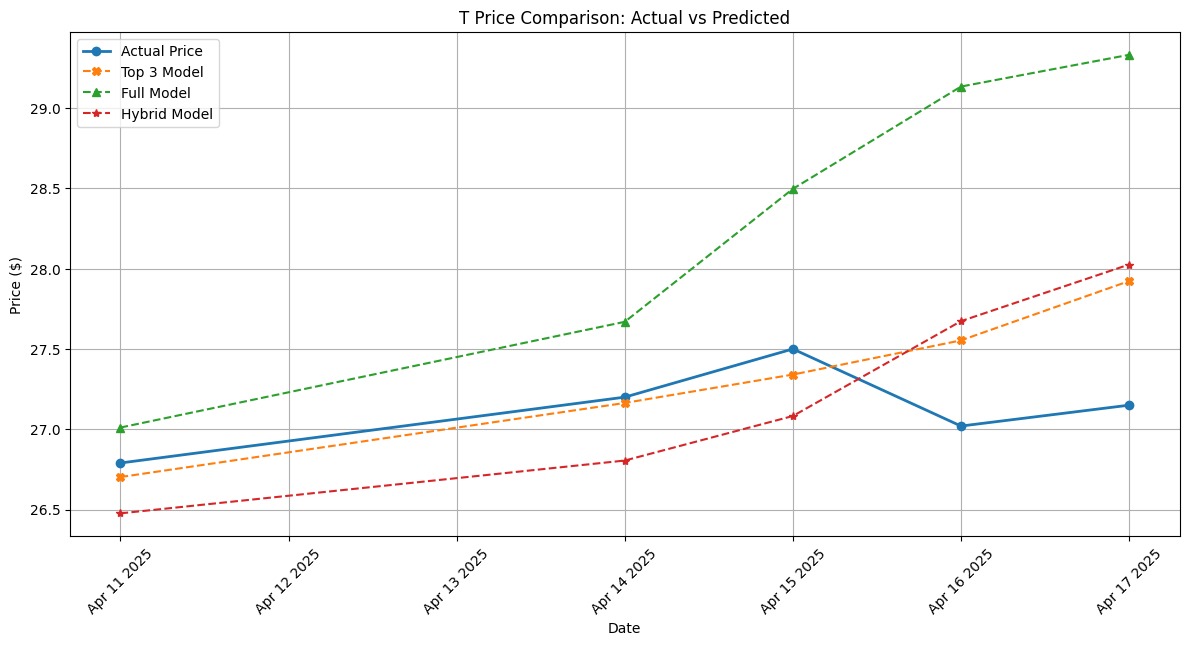

In [313]:
import matplotlib.dates as mdates

final_comparison.index = pd.to_datetime(final_comparison.index)

plt.figure(figsize=(12, 6))

# Plot
plt.plot(final_comparison.index, final_comparison['Actual_Price'], label='Actual Price', linewidth=2, marker="o")
plt.plot(final_comparison.index, final_comparison['Predicted_Price_Top3Model'], label='Top 3 Model', linestyle='--', marker="X")
plt.plot(final_comparison.index, final_comparison['Predicted_Price_FullModel'], label='Full Model', linestyle='--', marker="^")
plt.plot(final_comparison.index, final_comparison['Predicted_Price_HybridModel'], label='Hybrid Model', linestyle='--', marker="*")


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))  # 'Apr 07'
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Tick every day


plt.title(f"{ticker.upper()} Price Comparison: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Export data to csv to record

In [314]:
final_export_df = final_comparison.reset_index().rename(columns={'index': 'Date'})

start_date = final_export_df['Date'].min()
end_date = final_export_df['Date'].max()

date_range_str = f"{start_date.strftime('%B')}{start_date.day}-{end_date.day}"  # e.g., April11-17

#create filename
filename = f"{ticker.lower()}_{date_range_str}.csv"

# export
final_export_df.to_csv(filename, index=False)
print(f"Exported: {filename}")


Exported: t_April11-17.csv


# **Actual Forecasting using our 3 models**

In [315]:
# df_original

In [316]:
pred = pred.dropna()
pred

,close_t,high_t,low_t,open_t,volume_t,Actual_Return,return_lag_1,return_lag_2,return_lag_5,return_lag_10,...,middle_band,lower_band,band_distance,band_width,lag20_vol_interaction,volume_lag20_interaction,volume_zscore,vix_close,sp500_return_lag5,sp500_rolling_5
Date,,,,,,,,,,,,,,,,,,,,,
2005-02-22,4.283702,4.367487,4.278354,4.328269,15994052,-0.006204,-0.006204,-0.009072,-0.013952,-0.017981,...,4.325506,4.214703,-0.188641,0.221606,-0.000706,-3.323902e+05,-0.296329,11.520000,0.000697,-0.000609
2005-02-23,4.303314,4.321141,4.258748,4.285488,14219495,0.004578,0.004578,-0.001654,-0.015497,-0.019097,...,4.322743,4.212623,-0.088217,0.220242,-0.000380,-1.802849e+05,-0.517392,11.270000,0.003300,-0.003650
2005-02-24,4.306877,4.322921,4.276572,4.292616,8454005,0.000828,0.000828,0.005410,-0.014280,-0.009024,...,4.319000,4.212114,-0.056708,0.213771,-0.000509,-1.444566e+05,-1.107361,11.100000,0.000182,-0.003188
2005-02-25,4.315789,4.322920,4.265875,4.310442,10097354,0.002069,0.002069,0.002899,-0.001650,0.004564,...,4.323813,4.227091,-0.041477,0.193443,0.000648,2.303520e+05,-0.862709,11.770000,-0.007923,-0.001646
2005-02-28,4.289051,4.317573,4.278355,4.317573,10970399,-0.006195,-0.006195,-0.004139,-0.004963,-0.008244,...,4.327735,4.244234,-0.231636,0.167002,0.000570,2.043618e+05,-0.679767,11.180000,0.000700,0.001800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-11,26.790001,26.900000,26.360001,26.580000,32057600,0.015157,0.015157,0.022831,0.016304,-0.039235,...,27.011524,25.581762,-0.077468,2.859524,0.016616,5.962238e+05,-0.889937,45.310001,-0.059750,-0.003447
2025-04-14,27.200001,27.350000,26.580000,26.629999,27042800,0.015304,0.015304,0.030693,0.024551,-0.027981,...,27.044113,25.628434,0.055058,2.831357,0.020550,6.639234e+05,-1.086797,46.980000,-0.002331,0.012121
2025-04-15,27.500000,27.629999,27.260000,27.500000,25721300,0.011029,0.011029,0.026502,0.053122,-0.024161,...,27.102586,25.713271,0.143025,2.778630,0.033446,1.142411e+06,-1.131475,52.330002,-0.015701,0.014177


Get last known price from april 17th

In [317]:
# top3_features = top3_model.feature_name_
# clf_features = clf_top.feature_name_  # your classifier features
# # reg_features = reg.feature_name_  # from regressor trained on top 5 features


We define our features from models:

In [318]:
top3_features = top3_model.feature_name_
top5_features = reg_top5.feature_name_
clf_features = clf_top.feature_name_
full_features = reg_full.feature_name_


forecast row function:
takes in one row of input data (from your pred DataFrame), runs predictions using all three models, calculates the expected price and return for each

In [319]:
def generate_forecast_row(row):
    current_price = round(row[close_col], 2)
    start_date = row.name + timedelta(days=1)
    predicted_date = pd.bdate_range(start=start_date, periods=5)[-1]

    # Prepare model inputs
    X_input_top3 = row[top3_features].values.reshape(1, -1)
    X_input_top5 = row[top5_features].values.reshape(1, -1)
    X_input_clf = row[clf_features].values.reshape(1, -1)
    X_input_full = row[full_features].values.reshape(1, -1)

# predictions
    top3_pred_return = top3_model.predict(X_input_top3)[0]
    hybrid_pred_return = reg_top5.predict(X_input_top5)[0]
    full_pred_return = reg_full.predict(X_input_full)[0]
    clf_pred_direction = clf_top.predict(X_input_clf)[0]

    # Interpret predictions
    reg_direction = int(hybrid_pred_return > 0)
    hybrid_direction = int((clf_pred_direction == 1) and (reg_direction == 1))

    # Compute prices
    top3_price = round(current_price * (1 + top3_pred_return), 2)
    reg_price = round(current_price * (1 + full_pred_return), 2)
    hybrid_price = round(current_price * (1 + hybrid_pred_return), 2)

    return {
        'Prediction_Made_On': row.name.date(),
        'Predicted_Date': predicted_date.date(),
        'Current_Price': current_price,
        'Top3_Price': top3_price,
        'Top3_Return (%)': round(top3_pred_return * 100, 2),
        'Reg_Price': reg_price,
        'Reg_Return (%)': round(full_pred_return * 100, 2),
        'Hybrid_Price': hybrid_price,
        'Hybrid_Return (%)': round(hybrid_pred_return * 100, 2),
        'Hybrid_Direction': hybrid_direction
    }


Apply Forecasting to Latest 5 rows so we can get the predicted 5 day return:

In [320]:
forecast_inputs = pred.tail(5).copy()
forecast_rows = [generate_forecast_row(row) for _, row in forecast_inputs.iterrows()]


Display our forecast into table:

In [321]:
forecast_df = pd.DataFrame(forecast_rows)
forecast_df = forecast_df.sort_values(by='Prediction_Made_On').reset_index(drop=True)

#color our table:
styled_df = forecast_df.style.applymap(
    color_returns,
    subset=['Top3_Return (%)', 'Reg_Return (%)', 'Hybrid_Return (%)']
)

print(f"{ticker.upper()} Forecast Comparison with Hybrid Logic:")
display(styled_df)



T Forecast Comparison with Hybrid Logic:


,Prediction_Made_On,Predicted_Date,Current_Price,Top3_Price,Top3_Return (%),Reg_Price,Reg_Return (%),Hybrid_Price,Hybrid_Return (%),Hybrid_Direction
0,2025-04-11,2025-04-18,26.790000,26.380000,-1.540000,26.260000,-1.980000,26.000000,-2.960000,0
1,2025-04-14,2025-04-21,27.200000,27.230000,0.130000,26.970000,-0.840000,26.280000,-3.400000,0
2,2025-04-15,2025-04-22,27.500000,27.920000,1.520000,27.410000,-0.340000,27.350000,-0.560000,0
3,2025-04-16,2025-04-23,27.020000,27.130000,0.410000,27.640000,2.300000,26.710000,-1.150000,0
4,2025-04-17,2025-04-24,27.150000,27.170000,0.080000,26.820000,-1.200000,26.590000,-2.050000,0


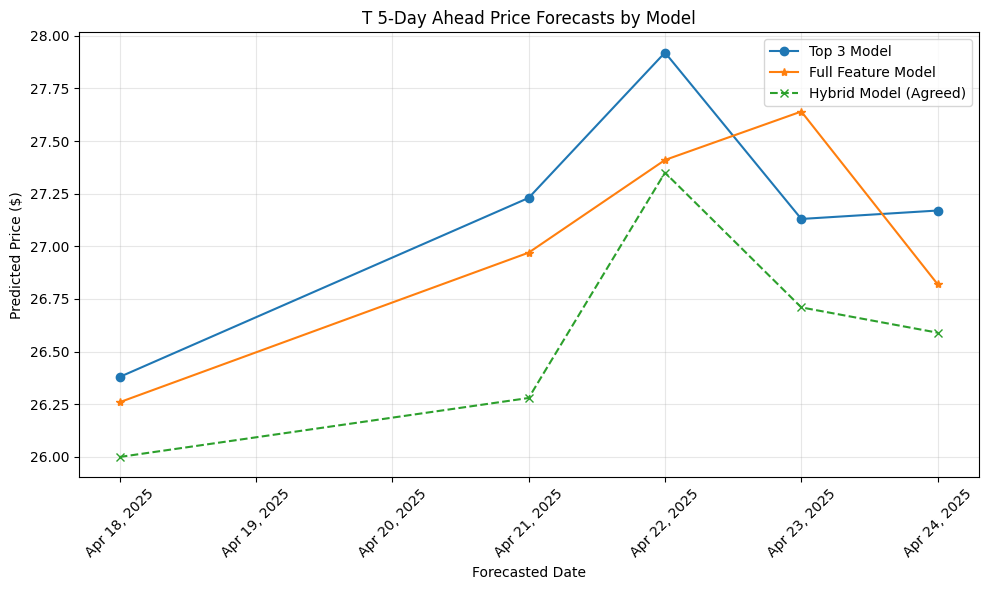

In [322]:

# Convert date column to datetime just in case
forecast_df['Predicted_Date'] = pd.to_datetime(forecast_df['Predicted_Date'])


plt.figure(figsize=(10, 6))

#plot models:
plt.plot(forecast_df['Predicted_Date'], forecast_df['Top3_Price'], marker='o', label='Top 3 Model')
plt.plot(forecast_df['Predicted_Date'], forecast_df['Reg_Price'], marker='*', label='Full Feature Model')
hybrid_valid = forecast_df[forecast_df['Hybrid_Price'].notna()]
plt.plot(hybrid_valid['Predicted_Date'], hybrid_valid['Hybrid_Price'], marker='x', linestyle='--', label='Hybrid Model (Agreed)')

#Format date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())


#plot
plt.title(f'{ticker.upper()} 5-Day Ahead Price Forecasts by Model')
plt.xlabel('Forecasted Date')
plt.ylabel('Predicted Price ($)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()
